In [ ]:
# testing pretrained model
# %pip install torch torchvision matplotlib
# %pip install lime
# %pip install opencv-python

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import numpy as np
import torchvision.transforms.functional as F
import cv2
import random
import os

In [6]:
class EdgeEnhancementTransform:
    def __call__(self, img):
        img = np.array(F.to_grayscale(img))  # Convert to grayscale
        img = cv2.GaussianBlur(img, (3, 3), 0)  # Reduce noise
        edges = cv2.Laplacian(img, cv2.CV_64F)  # Edge detection
        edges = np.clip((edges - edges.min()) / (edges.max() - edges.min()) * 255, 0, 255).astype(np.uint8)
        return F.to_tensor(np.stack([edges] * 3, axis=-1))  # Stack to 3 channels

# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([EdgeEnhancementTransform()], p=0.5),  # Apply edge emphasis randomly
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjusted normalization
])
# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [3]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

c:\Users\yisye\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Number of training samples: 2388
Number of testing samples: 598


In [4]:
# data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# loading ResNet50 (pretrained model for transfer learning)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = len(class_names)
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.fc.in_features, num_classes)
) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [6]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [7]:
# Training loop
epochs = 50
print("Training started...")

loss_train = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss = loss.item()
    loss_train.append(epoch_loss)
    
    print(f"{datetime.datetime.now().time()} Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Training started...
18:02:10.956360 Epoch 1/50, Loss: 0.9474
18:02:54.467363 Epoch 2/50, Loss: 0.6380
18:03:44.191747 Epoch 3/50, Loss: 0.4569
18:04:28.043814 Epoch 4/50, Loss: 0.2809
18:05:10.489095 Epoch 5/50, Loss: 0.2955
18:05:54.007685 Epoch 6/50, Loss: 0.2672
18:06:36.766634 Epoch 7/50, Loss: 0.2061
18:07:20.612774 Epoch 8/50, Loss: 0.1712
18:08:04.803268 Epoch 9/50, Loss: 0.1780
18:08:48.707009 Epoch 10/50, Loss: 0.1427
18:09:31.952172 Epoch 11/50, Loss: 0.1355
18:10:18.225690 Epoch 12/50, Loss: 0.1631
18:11:05.714850 Epoch 13/50, Loss: 0.1040
18:11:43.827081 Epoch 14/50, Loss: 0.1021
18:12:21.154994 Epoch 15/50, Loss: 0.0881
18:12:58.564967 Epoch 16/50, Loss: 0.0726
18:13:53.466400 Epoch 17/50, Loss: 0.0860
18:14:35.385071 Epoch 18/50, Loss: 0.1103
18:15:13.962927 Epoch 19/50, Loss: 0.1339
18:15:56.492067 Epoch 20/50, Loss: 0.0638
18:16:52.259521 Epoch 21/50, Loss: 0.0663
18:17:36.026158 Epoch 22/50, Loss: 0.0544
18:18:14.687437 Epoch 23/50, Loss: 0.0796
18:18:56.548595 Epoch 2

Text(0.5, 1.0, 'Training Loss')

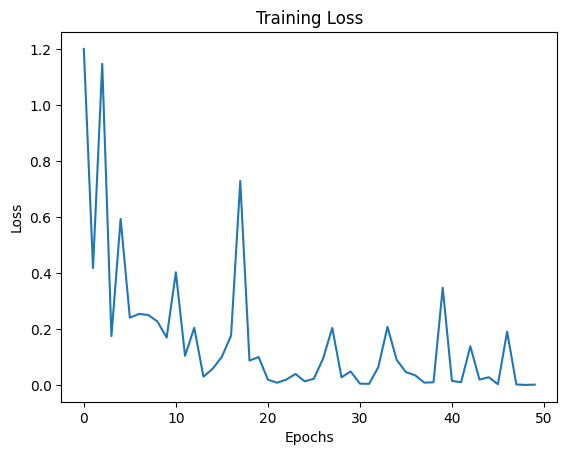

In [8]:
plt.plot(loss_train)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

In [8]:
# # Prepare Stratified K-Fold Cross-Validation
# K = 5  # Number of folds
# skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
# indices = np.arange(len(full_dataset))
# targets = np.array([full_dataset.targets[i] for i in range(len(full_dataset))])

# # Training parameaters
# batch_size = 32
# epochs = 5  # Adjust based on training time

# # Store performance metrics
# fold_accuracies = []
# fold_f1_scores = []

# # K-Fold Cross-Validation loop
# for fold, (train_idx, val_idx) in enumerate(skf.split(indices, targets)):
#     print(f"\nFold {fold + 1}/{K}")

#     # Create train and validation subsets
#     train_subset = Subset(full_dataset, train_idx)
#     val_subset = Subset(full_dataset, val_idx)

#     # Create data loaders
#     train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

#     # Load ResNet50 model
#     model = models.resnet50(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False  # Freeze pretrained layers

#     # Modify fully connected layer with dropout
#     model.fc = nn.Sequential(
#         nn.Dropout(p=0.1),
#         nn.Linear(model.fc.in_features, num_classes)
#     )

#     model = model.to(device)

#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

#     # Validation loop
#     model.eval()
#     correct, total = 0, 0
#     true_labels, predicted_labels = [], []

#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())

#     # Calculate metrics
#     accuracy = 100 * correct / total
#     fscore = f1_score(true_labels, predicted_labels, average='macro')

#     fold_accuracies.append(accuracy)
#     fold_f1_scores.append(fscore)

#     print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")
#     print(f"Fold {fold + 1} F1-Score: {fscore:.4f}")

# # Print final K-Fold results
# print("\nFinal Cross-Validation Results:")
# print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")
# print(f"Average F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")

In [9]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score (Macro for Multi-class)
fscore = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'resnet50_model6.pth')
print("Model saved.")

c:\Users\yisye\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Testing Accuracy: 91.30%
F1-Score: 0.9130
Model saved.


In [11]:
import scikitplot as skplt
from sklearn.metrics import classification_report

skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']))

ImportError: cannot import name 'interp' from 'scipy' (c:\Users\yisye\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\__init__.py)

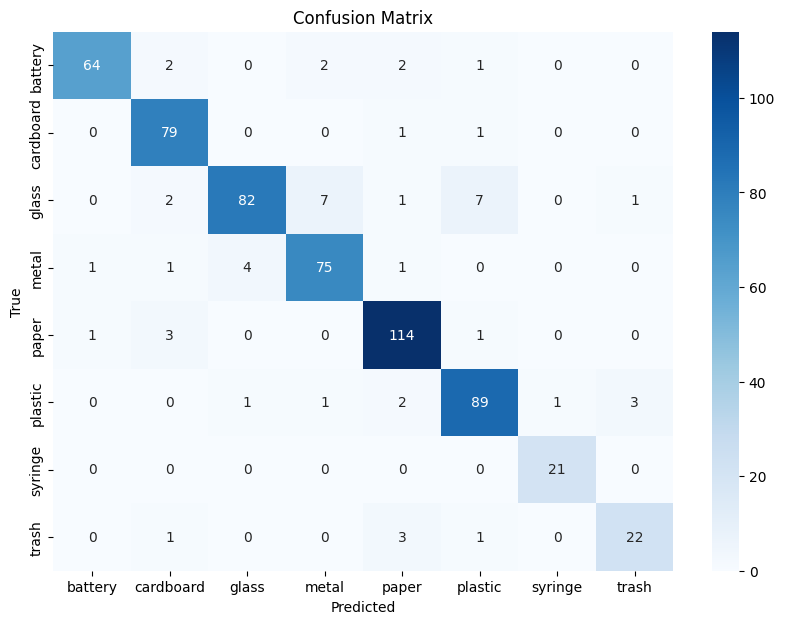

              precision    recall  f1-score   support

     battery       0.97      0.90      0.93        71
   cardboard       0.90      0.98      0.93        81
       glass       0.94      0.82      0.88       100
       metal       0.88      0.91      0.90        82
       paper       0.92      0.96      0.94       119
     plastic       0.89      0.92      0.90        97
     syringe       0.95      1.00      0.98        21
       trash       0.85      0.81      0.83        27

    accuracy                           0.91       598
   macro avg       0.91      0.91      0.91       598
weighted avg       0.91      0.91      0.91       598



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash'], yticklabels=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']))